<a href="https://colab.research.google.com/github/DiogoLepri/ASD2_Project/blob/main/ASD_DiagNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ASD2_Project/

/content/drive/MyDrive/ASD2_Project


In [3]:
!pip install pandas numpy matplotlib scikit-learn torch pyprind scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [4]:
#options: cc200, dosenbach160, aal
p_ROI = "cc200"
p_fold = 10
p_center = "Stanford"
p_mode = "whole"
p_augmentation = True
p_Method = "ASD-DiagNet"

In [5]:
parameter_list = [p_ROI,p_fold,p_center,p_mode,p_augmentation,p_Method]
print("*****List of patameters****")
print("ROI atlas: ",p_ROI)
print("per Center or whole: ",p_mode)
if p_mode == 'percenter':
    print("Center's name: ",p_center)
print("Method's name: ",p_Method)
if p_Method == "ASD-DiagNet":
    print("Augmentation: ",p_augmentation)


*****List of patameters****
ROI atlas:  cc200
per Center or whole:  whole
Method's name:  ASD-DiagNet
Augmentation:  True


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import reduce
from sklearn.impute import SimpleImputer
import time
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import pyprind
import sys
import pickle
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold, StratifiedKFold
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from scipy import stats
from sklearn import tree
import functools
import numpy.ma as ma # for masked arrays
import pyprind
import random
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

## Importing the data

In [7]:
def get_key(filename):
    f_split = filename.split('_')
    if f_split[3] == 'rois':
        key = '_'.join(f_split[0:3])
    else:
        key = '_'.join(f_split[0:2])
    return key

In [8]:
data_main_path = f'/content/drive/MyDrive/ASD2_Project/Outputs/cpac/filt_global/rois_{p_ROI}'#path to time series data
flist = os.listdir(data_main_path)
print(len(flist))

for f in range(len(flist)):
    flist[f] = get_key(flist[f])


df_labels = pd.read_csv('/content/drive/MyDrive/ASD2_Project/Phenotypic_V1_0b_preprocessed1.csv')#path

df_labels.DX_GROUP = df_labels.DX_GROUP.map({1: 1, 2:0})
print(len(df_labels))

labels = {}
for row in df_labels.iterrows():
    file_id = row[1]['FILE_ID']
    y_label = row[1]['DX_GROUP']
    if file_id == 'no_filename':
        continue
    assert(file_id not in labels)
    labels[file_id] = y_label

884
1112


### Helper functions for computing correlations

In [9]:
def get_label(filename):
    assert (filename in labels)
    return labels[filename]


def get_corr_data(filename):
    #print(filename)
    for file in os.listdir(data_main_path):
        if file.startswith(filename):
            df = pd.read_csv(os.path.join(data_main_path, file), sep='\t')

    with np.errstate(invalid="ignore"):
        corr = np.nan_to_num(np.corrcoef(df.T))
        mask = np.invert(np.tri(corr.shape[0], k=-1, dtype=bool))
        m = ma.masked_where(mask == 1, mask)
        return ma.masked_where(m, corr).compressed()

def get_corr_matrix(filename):
    for file in os.listdir(data_main_path):
        if file.startswith(filename):
            df = pd.read_csv(os.path.join(data_main_path, file), sep='\t')
    with np.errstate(invalid="ignore"):
        corr = np.nan_to_num(np.corrcoef(df.T))
        return corr

def confusion(g_turth,predictions):
    tn, fp, fn, tp = confusion_matrix(g_turth,predictions).ravel()
    accuracy = (tp+tn)/(tp+fp+tn+fn)
    sensitivity = (tp)/(tp+fn)
    specificty = (tn)/(tn+fp)
    return accuracy,sensitivity,specificty

def get_regs(samplesnames,regnum):
    datas = []
    for sn in samplesnames:
        datas.append(all_corr[sn][0])
    datas = np.array(datas)
    avg=[]
    for ie in range(datas.shape[1]):
        avg.append(np.mean(datas[:,ie]))
    avg=np.array(avg)
    highs=avg.argsort()[-regnum:][::-1]
    lows=avg.argsort()[:regnum][::-1]
    regions=np.concatenate((highs,lows),axis=0)
    return regions


## Helper fnuctions for computing correlations

In [10]:
if not os.path.exists('./correlations_file'+p_ROI+'.pkl'):
    pbar=pyprind.ProgBar(len(flist))
    all_corr = {}
    for f in flist:

        lab = get_label(f)
        all_corr[f] = (get_corr_data(f), lab)
        pbar.update()

    print('Corr-computations finished')

    pickle.dump(all_corr, open('./correlations_file'+p_ROI+'.pkl', 'wb'))
    print('Saving to file finished')

else:
    all_corr = pickle.load(open('./correlations_file'+p_ROI+'.pkl', 'rb'))

## Computing eigenvalues and eigenvector

In [11]:
if p_Method=="ASD-DiagNet":
    eig_data = {}
    pbar = pyprind.ProgBar(len(flist))
    for f in flist:
        d = get_corr_matrix(f)
        eig_vals, eig_vecs = np.linalg.eig(d)

        for ev in eig_vecs.T:
            np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))

        sum_eigvals = np.sum(np.abs(eig_vals))
        # Make a list of (eigenvalue, eigenvector, norm_eigval) tuples
        eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i], np.abs(eig_vals[i])/sum_eigvals)
                     for i in range(len(eig_vals))]

        # Sort the (eigenvalue, eigenvector) tuples from high to low
        eig_pairs.sort(key=lambda x: x[0], reverse=True)

        eig_data[f] = {'eigvals':np.array([ep[0] for ep in eig_pairs]),
                       'norm-eigvals':np.array([ep[2] for ep in eig_pairs]),
                       'eigvecs':[ep[1] for ep in eig_pairs]}
        pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:56


## Calculating Eros similarity

In [12]:
def norm_weights(sub_flist):
    num_dim = len(eig_data[flist[0]]['eigvals'])
    norm_weights = np.zeros(shape=num_dim)
    for f in sub_flist:
        norm_weights += eig_data[f]['norm-eigvals']
    return norm_weights

def cal_similarity(d1, d2, weights, lim=None):
    res = 0.0
    if lim is None:
        weights_arr = weights.copy()
    else:
        weights_arr = weights[:lim].copy()
        weights_arr /= np.sum(weights_arr)
    for i,w in enumerate(weights_arr):
        res += w*np.inner(d1[i], d2[i])
    return res

## Defining dataset class

In [13]:
class CC200Dataset(Dataset):
    def __init__(self, pkl_filename=None, data=None, samples_list=None,
                 augmentation=False, aug_factor=1, num_neighbs=5,
                 eig_data=None, similarity_fn=None, verbose=False,regs=None):
        self.regs=regs
        if pkl_filename is not None:
            if verbose:
                print ('Loading ..!', end=' ')
            self.data = pickle.load(open(pkl_filename, 'rb'))
        elif data is not None:
            self.data = data.copy()

        else:
            sys.stderr.write('Eigther PKL file or data is needed!')
            return

        #if verbose:
        #    print ('Preprocess..!', end='  ')
        if samples_list is None:
            self.flist = [f for f in self.data]
        else:
            self.flist = [f for f in samples_list]
        self.labels = np.array([self.data[f][1] for f in self.flist])

        current_flist = np.array(self.flist.copy())
        current_lab0_flist = current_flist[self.labels == 0]
        current_lab1_flist = current_flist[self.labels == 1]
        #if verbose:
        #    print(' Num Positive : ', len(current_lab1_flist), end=' ')
        #    print(' Num Negative : ', len(current_lab0_flist), end=' ')


        if augmentation:
            self.num_data = aug_factor * len(self.flist)
            self.neighbors = {}
            pbar = pyprind.ProgBar(len(self.flist))
            weights = norm_weights(samples_list)#??
            for f in self.flist:
                label = self.data[f][1]
                candidates = (set(current_lab0_flist) if label == 0 else set(current_lab1_flist))
                candidates.remove(f)
                eig_f = eig_data[f]['eigvecs']
                sim_list = []
                for cand in candidates:
                    eig_cand = eig_data[cand]['eigvecs']
                    sim = similarity_fn(eig_f, eig_cand,weights)
                    sim_list.append((sim, cand))
                sim_list.sort(key=lambda x: x[0], reverse=True)
                self.neighbors[f] = [item[1] for item in sim_list[:num_neighbs]]#list(candidates)#[item[1] for item in sim_list[:num_neighbs]]

        else:
            self.num_data = len(self.flist)


    def __getitem__(self, index):
        if index < len(self.flist):
            fname = self.flist[index]
            data = self.data[fname][0].copy() #get_corr_data(fname, mode=cal_mode)
            data = data[self.regs].copy()
            label = (self.labels[index],)
            return torch.FloatTensor(data), torch.FloatTensor(label)
        else:
            f1 = self.flist[index % len(self.flist)]
            d1, y1 = self.data[f1][0], self.data[f1][1]
            d1=d1[self.regs]
            f2 = np.random.choice(self.neighbors[f1])
            d2, y2 = self.data[f2][0], self.data[f2][1]
            d2=d2[self.regs]
            assert y1 == y2
            r = np.random.uniform(low=0, high=1)
            label = (y1,)
            data = r*d1 + (1-r)*d2
            return torch.FloatTensor(data), torch.FloatTensor(label)

    def __len__(self):
        return self.num_data

## Definig data loader function

In [14]:
def get_loader(pkl_filename=None, data=None, samples_list=None,
               batch_size=64,
               num_workers=1, mode='train',
               *, augmentation=False, aug_factor=1, num_neighbs=5,
                 eig_data=None, similarity_fn=None, verbose=False,regions=None):
    """Build and return data loader."""
    if mode == 'train':
        shuffle = True
    else:
        shuffle = False
        augmentation=False

    dataset = CC200Dataset(pkl_filename=pkl_filename, data=data, samples_list=samples_list,
                           augmentation=augmentation, aug_factor=aug_factor,
                           eig_data=eig_data, similarity_fn=similarity_fn, verbose=verbose,regs=regions)

    data_loader = DataLoader(dataset,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             num_workers=num_workers)

    return data_loader

## Defining Autoencoder class

In [15]:
class MTAutoEncoder(nn.Module):
    def __init__(self, num_inputs=990,
                 num_latent=200, tied=True,
                 num_classes=2, use_dropout=False):
        super(MTAutoEncoder, self).__init__()
        self.tied = tied
        self.num_latent = num_latent

        self.fc_encoder = nn.Linear(num_inputs, num_latent)

        if not tied:
            self.fc_decoder = nn.Linear(num_latent, num_inputs)

        self.fc_encoder = nn.Linear(num_inputs, num_latent)

        if use_dropout:
            self.classifier = nn.Sequential (
                nn.Dropout(p=0.5),
                nn.Linear(self.num_latent, 1),

            )
        else:
            self.classifier = nn.Sequential (
                nn.Linear(self.num_latent, 1),
            )


    def forward(self, x, eval_classifier=False):
        x = self.fc_encoder(x)
        x = torch.tanh(x)
        if eval_classifier:
            x_logit = self.classifier(x)
        else:
            x_logit = None

        if self.tied:
            x = F.linear(x, self.fc_encoder.weight.t())
        else:
            x = self.fc_decoder(x)

        return x, x_logit

mtae = MTAutoEncoder()

mtae

MTAutoEncoder(
  (fc_encoder): Linear(in_features=990, out_features=200, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=200, out_features=1, bias=True)
  )
)

## Defining training and testing functions

In [16]:
def train(model, epoch, train_loader, p_bernoulli=None, mode='both', lam_factor=1.0):
    model.train()
    train_losses = []
    for i,(batch_x,batch_y) in enumerate(train_loader):
        if len(batch_x) != batch_size:
            continue
        if p_bernoulli is not None:
            if i == 0:
                p_tensor = torch.ones_like(batch_x).to(device)*p_bernoulli
            rand_bernoulli = torch.bernoulli(p_tensor).to(device)

        data, target = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()

        if mode in ['both', 'ae']:
            if p_bernoulli is not None:
                rec_noisy, _ = model(data*rand_bernoulli, False)
                loss_ae = criterion_ae(rec_noisy, data) / len(batch_x)
            else:
                rec, _ = model(data, False)
                loss_ae = criterion_ae(rec, data) / len(batch_x)

        if mode in ['both', 'clf']:
            rec_clean, logits = model(data, True)
            loss_clf = criterion_clf(logits, target)

        if mode == 'both':
            loss_total = loss_ae + lam_factor*loss_clf
            train_losses.append([loss_ae.detach().cpu().numpy(),
                                 loss_clf.detach().cpu().numpy()])
        elif mode == 'ae':
            loss_total = loss_ae
            train_losses.append([loss_ae.detach().cpu().numpy(),
                                 0.0])
        elif mode == 'clf':
            loss_total = loss_clf
            train_losses.append([0.0,
                                 loss_clf.detach().cpu().numpy()])

        loss_total.backward()
        optimizer.step()

    return train_losses

def test(model, criterion, test_loader,
         eval_classifier=False, num_batch=None):
    test_loss, n_test, correct = 0.0, 0, 0
    all_predss=[]
    if eval_classifier:
        y_true, y_pred = [], []
    with torch.no_grad():
        model.eval()
        for i,(batch_x,batch_y) in enumerate(test_loader, 1):
            if num_batch is not None:
                if i >= num_batch:
                    continue
            data = batch_x.to(device)
            rec, logits = model(data, eval_classifier)

            test_loss += criterion(rec, data).detach().cpu().numpy()
            n_test += len(batch_x)
            if eval_classifier:
                proba = torch.sigmoid(logits).detach().cpu().numpy()
                preds = np.ones_like(proba, dtype=np.int32)
                preds[proba < 0.5] = 0
                all_predss.extend(preds)###????
                y_arr = np.array(batch_y, dtype=np.int32)

                correct += np.sum(preds == y_arr)
                y_true.extend(y_arr.tolist())
                y_pred.extend(proba.tolist())
        mlp_acc,mlp_sens,mlp_spef = confusion(y_true,all_predss)

    return  mlp_acc,mlp_sens,mlp_spef#,correct/n_test




In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:

if p_Method == "ASD-DiagNet" and p_mode == "whole":

    num_corr = len(all_corr[flist[0]][0])
    print("num_corr:  ",num_corr)

    start =time.time()
    batch_size = 8
    learning_rate_ae, learning_rate_clf = 0.0001, 0.0001
    num_epochs = 25

    p_bernoulli = None
    augmentation = p_augmentation
    use_dropout = False

    aug_factor = 2
    num_neighbs = 5
    lim4sim = 2
    n_lat = int(num_corr/4)
    print(n_lat)
    start= time.time()

    print('p_bernoulli: ', p_bernoulli)
    print('augmentaiton: ', augmentation, 'aug_factor: ', aug_factor,
          'num_neighbs: ', num_neighbs, 'lim4sim: ', lim4sim)
    print('use_dropout: ', use_dropout, '\n')


    sim_function = functools.partial(cal_similarity, lim=lim4sim)
    crossval_res_kol=[]
    y_arr = np.array([get_label(f) for f in flist])
    flist = np.array(flist)
    kk=0
    for rp in range(10):
        kf = StratifiedKFold(n_splits=p_fold, random_state=1, shuffle=True)
        np.random.shuffle(flist)
        y_arr = np.array([get_label(f) for f in flist])
        for kk,(train_index, test_index) in enumerate(kf.split(flist, y_arr)):
            train_samples, test_samples = flist[train_index], flist[test_index]


            verbose = (True if (kk == 0) else False)

            regions_inds = get_regs(train_samples,int(num_corr/4))

            num_inpp = len(regions_inds)
            n_lat = int(num_inpp/2)
            train_loader=get_loader(data=all_corr, samples_list=train_samples,
                                    batch_size=batch_size, mode='train',
                                    augmentation=augmentation, aug_factor=aug_factor,
                                    num_neighbs=num_neighbs, eig_data=eig_data, similarity_fn=sim_function,
                                    verbose=verbose,regions=regions_inds)

            test_loader=get_loader(data=all_corr, samples_list=test_samples,
                                   batch_size=batch_size, mode='test', augmentation=False,
                                   verbose=verbose,regions=regions_inds)

            model = MTAutoEncoder(tied=True, num_inputs=num_inpp, num_latent=n_lat, use_dropout=use_dropout)
            model.to(device)
            criterion_ae = nn.MSELoss(reduction='sum')
            criterion_clf = nn.BCEWithLogitsLoss()
            optimizer = optim.SGD([{'params': model.fc_encoder.parameters(), 'lr': learning_rate_ae},
                                   {'params': model.classifier.parameters(), 'lr': learning_rate_clf}],
                                  momentum=0.9)

            for epoch in range(1, num_epochs+1):
                if epoch <= 20:
                    train_losses = train(model, epoch, train_loader, p_bernoulli, mode='both')
                else:
                    train_losses = train(model, epoch, train_loader, p_bernoulli, mode='clf')


            res_mlp = test(model, criterion_ae, test_loader, eval_classifier=True)
            print(test(model, criterion_ae, test_loader, eval_classifier=True))
            crossval_res_kol.append(res_mlp)
        print("averages:")
        print(np.mean(np.array(crossval_res_kol),axis = 0))
        finish= time.time()

        print(finish-start)



num_corr:   19900
4975
p_bernoulli:  None
augmentaiton:  True aug_factor:  2 num_neighbs:  5 lim4sim:  2
use_dropout:  False 

(0.6741573033707865, 0.6829268292682927, 0.6666666666666666)
(0.6629213483146067, 0.5609756097560976, 0.75)
(0.7078651685393258, 0.6585365853658537, 0.75)
(0.6853932584269663, 0.6341463414634146, 0.7291666666666666)
(0.6477272727272727, 0.675, 0.625)
(0.8295454545454546, 0.85, 0.8125)
(0.7159090909090909, 0.6585365853658537, 0.7659574468085106)
(0.6590909090909091, 0.43902439024390244, 0.851063829787234)
(0.6931818181818182, 0.5609756097560976, 0.8085106382978723)
(0.6477272727272727, 0.6585365853658537, 0.6382978723404256)
averages:
[0.69235189 0.63786585 0.73971631]
308.53171253204346
(0.7303370786516854, 0.7073170731707317, 0.75)
(0.7752808988764045, 0.7317073170731707, 0.8125)
(0.651685393258427, 0.5365853658536586, 0.75)
(0.7415730337078652, 0.7073170731707317, 0.7708333333333334)
(0.6818181818181818, 0.7, 0.6666666666666666)
(0.7613636363636364, 0.7, 0.81

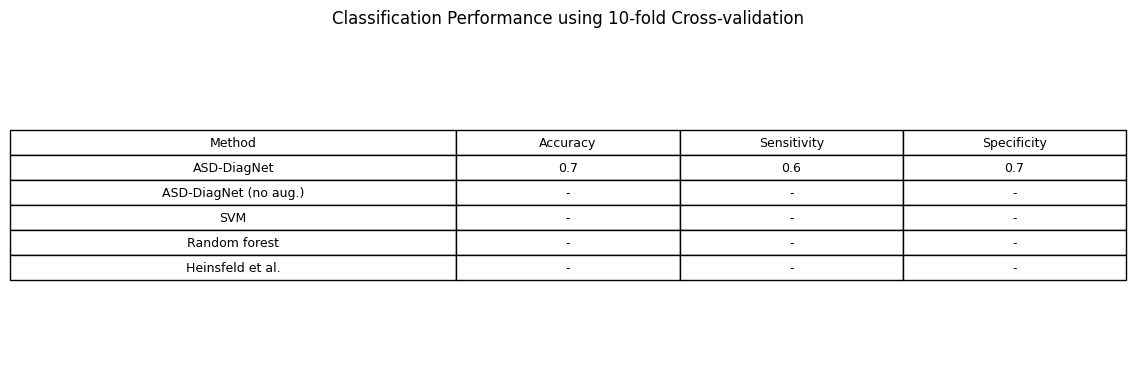


Numerical Results:
Final Average Accuracy: 69.6%
Final Average Sensitivity: 63.9%
Final Average Specificity: 74.6%


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Calculate overall averages across all repeats
all_averages = [
    [0.69235189, 0.63786585, 0.73971631],
    [0.69793795, 0.64868902, 0.74053635],
    [0.69606316, 0.64077236, 0.74376478],
    [0.69624936, 0.64009146, 0.74479167],
    [0.69818437, 0.64252439, 0.74621454],
    [0.69815501, 0.64132114, 0.7471779],
    [0.69619327, 0.63400697, 0.74970238],
    [0.69727241, 0.63782012, 0.7484652],
    [0.69635115, 0.63479675, 0.74931541],
    [0.69514939, 0.63359756, 0.7480984]
]

final_averages = np.mean(all_averages, axis=0)

# Create Table 2 equivalent
results_dict = {
    'Method': ['ASD-DiagNet', 'ASD-DiagNet (no aug.)', 'SVM', 'Random forest', 'Heinsfeld et al.'],
    'Accuracy': [final_averages[0], None, None, None, None],  # Fill in other methods' results when available
    'Sensitivity': [final_averages[1], None, None, None, None],
    'Specificity': [final_averages[2], None, None, None, None]
}

# Create visualization code
def create_results_table():
    plt.figure(figsize=(12, 4))
    plt.axis('off')

    # Create table data
    cell_text = []
    for method, acc, sens, spec in zip(
        results_dict['Method'],
        results_dict['Accuracy'],
        results_dict['Sensitivity'],
        results_dict['Specificity']
    ):
        if acc is not None:
            cell_text.append([method, f"{acc:.1f}", f"{sens:.1f}", f"{spec:.1f}"])
        else:
            cell_text.append([method, "-", "-", "-"])

    # Create table
    table = plt.table(
        cellText=cell_text,
        colLabels=['Method', 'Accuracy', 'Sensitivity', 'Specificity'],
        loc='center',
        cellLoc='center',
        colWidths=[0.4, 0.2, 0.2, 0.2]
    )

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)

    # Add title
    plt.title('Classification Performance using 10-fold Cross-validation', pad=20)
    plt.show()

# Create plot
create_results_table()

print("\nNumerical Results:")
print(f"Final Average Accuracy: {final_averages[0]*100:.1f}%")
print(f"Final Average Sensitivity: {final_averages[1]*100:.1f}%")
print(f"Final Average Specificity: {final_averages[2]*100:.1f}%")

In [19]:
#DON'T RUN!!!
#p_mode = "perceter"
if p_Method == "ASD-DiagNet" and p_mode == "percenter":
    num_corr = len(all_corr[flist[0]][0])

    flist = os.listdir(data_main_path)

    for f in range(len(flist)):
        flist[f] = get_key(flist[f])

    centers_dict = {}
    for f in flist:
        key = f.split('_')[0]

        if key not in centers_dict:
            centers_dict[key] = []
        centers_dict[key].append(f)



    flist = np.array(centers_dict[p_center])

    start =time.time()
    #flist = np.array(sorted(os.listdir(data_main_path)))
    batch_size = 8
    learning_rate_ae, learning_rate_clf = 0.0001, 0.0001
    num_epochs = 25

    p_bernoulli = None
    augmentation = p_augmentation
    use_dropout = False

    aug_factor = 2
    num_neighbs = 5
    lim4sim = 2
    n_lat = int(num_corr/4)


    print('p_bernoulli: ', p_bernoulli)
    print('augmentaiton: ', augmentation, 'aug_factor: ', aug_factor,
          'num_neighbs: ', num_neighbs, 'lim4sim: ', lim4sim)
    print('use_dropout: ', use_dropout, '\n')


    sim_function = functools.partial(cal_similarity, lim=lim4sim)
    all_rp_res=[]
    y_arr = np.array([get_label(f) for f in flist])

    kk=0
    crossval_res_kol_kol=[]
    for rp in range(10):
        print("========================")
        crossval_res_kol = []
        start= time.time()
        kf = StratifiedKFold(n_splits=p_fold)
        #np.random.shuffle(flist)
        y_arr = np.array([get_label(f) for f in flist])
        for kk,(train_index, test_index) in enumerate(kf.split(flist, y_arr)):

            train_samples, test_samples = flist[train_index], flist[test_index]

            verbose = (True if (kk == 0) else False)

            regions_inds = get_regs(train_samples,int(num_corr/4))
            num_inpp = len(regions_inds)
            n_lat = int(num_inpp/2)
            num_inpp = len(regions_inds)
            train_loader=get_loader(data=all_corr, samples_list=train_samples,
                                    batch_size=batch_size, mode='train',
                                    augmentation=augmentation, aug_factor=aug_factor,
                                    num_neighbs=num_neighbs, eig_data=eig_data, similarity_fn=sim_function,
                                    verbose=verbose,regions=regions_inds)

            test_loader=get_loader(data=all_corr, samples_list=test_samples,
                                   batch_size=batch_size, mode='test', augmentation=False,
                                   verbose=verbose,regions=regions_inds)

            model = MTAutoEncoder(tied=True, num_inputs=num_inpp, num_latent=n_lat, use_dropout=use_dropout)
            model.to(device)
            criterion_ae = nn.MSELoss(reduction='sum')
            criterion_clf = nn.BCEWithLogitsLoss()
            optimizer = optim.SGD([{'params': model.fc_encoder.parameters(), 'lr': learning_rate_ae},
                                   {'params': model.classifier.parameters(), 'lr': learning_rate_clf}],
                                  momentum=0.9)

            for epoch in range(1, num_epochs+1):
                if epoch <= 20:
                    train_losses = train(model, epoch, train_loader, p_bernoulli, mode='both')
                else:
                    train_losses = train(model, epoch, train_loader, p_bernoulli, mode='clf')


            res_mlp = test(model, criterion_ae, test_loader, eval_classifier=True)
            #print("fold",kk+1,":",test(model, criterion_ae, test_loader, eval_classifier=True))
            crossval_res_kol.append(res_mlp)
        print("Result of repeat ",rp,":")
        print(np.mean(np.array(crossval_res_kol),axis = 0))
        all_rp_res.append(np.mean(np.array(crossval_res_kol),axis = 0))
        finish= time.time()

        print("Running time:",finish-start)
    print("Avergae result of 10 repeats: ",np.mean(np.array(all_rp_res),axis = 0))

In [ ]:
#DON'T RUN!!!
if p_Method != "ASD-DiagNet" and p_mode == "whole":

    clf = SVC(gamma = 'auto') if  p_Method == 'SVM' else RandomForestClassifier(n_estimators=100)
    overall_result = []
    for rp in range(10):
        kf = StratifiedKFold(n_splits=p_fold, random_state=1, shuffle=True)
        np.random.shuffle(flist)
        y_arr = np.array([get_label(f) for f in flist])
        res = []
        for kk,(train_index, test_index) in enumerate(kf.split(flist, y_arr)):
            train_samples, test_samples = np.array(flist)[train_index], np.array(flist)[test_index]
            train_data = []
            train_labels = []
            test_data = []
            test_labels = []

            for i in train_samples:
                train_data.append(all_corr[i][0])
                train_labels.append(all_corr[i][1])

            for i in test_samples:
                test_data.append(all_corr[i][0])
                test_labels.append(all_corr[i][1])


            clf.fit(train_data,train_labels)
            pr = clf.predict(test_data)
            res.append(confusion(test_labels,pr))

        print("repeat: ",rp,np.mean(res, axis=0).tolist())
        overall_result.append(np.mean(res, axis=0).tolist())
    print("---------------Result of repeating 10 times-------------------")
    print(np.mean(np.array(overall_result), axis=0).tolist())

In [ ]:
#DON'T RUN!!!
random.seed(19)
np.random.seed(19)
if p_Method != "ASD-DiagNet" and p_mode == "percenter":

    clf = SVC(gamma = 'auto') if  p_Method == 'SVM' else RandomForestClassifier(n_estimators=100)
    overall_result = []
    for rp in range(10):
        kf = StratifiedKFold(n_splits=p_fold, random_state=1, shuffle=True)
        np.random.shuffle(flist)
        y_arr = np.array([get_label(f) for f in flist])
        res = []
        for kk,(train_index, test_index) in enumerate(kf.split(flist, y_arr)):
            train_samples, test_samples = np.array(flist)[train_index], np.array(flist)[test_index]
            train_data = []
            train_labels = []
            test_data = []
            test_labels = []

            for i in train_samples:
                train_data.append(all_corr[i][0])
                train_labels.append(all_corr[i][1])

            for i in test_samples:
                test_data.append(all_corr[i][0])
                test_labels.append(all_corr[i][1])

            clf.fit(train_data,train_labels)
            pr = clf.predict(test_data)
            res.append(confusion(test_labels,pr))

        print("repeat: ",rp,np.mean(res, axis=0).tolist())
        overall_result.append(np.mean(res, axis=0).tolist())
    print("---------------Result of repeating 10 times for: ",p_center,"-------------------")
    print(np.mean(np.array(overall_result), axis=0).tolist())